In [1]:
import os
os.chdir("../../../../")

import itertools
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy

#!pip install pmdarima
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import model_selection
from pmdarima import auto_arima
from scripts.python.tsa.ts_utils import * 
from scripts.python.tsa.utsmodel import * 
from scripts.python.tsa.mtsmodel import * 
from scripts.python.tsa.ts_eval import *
from sarimaxs import *

import warnings
warnings.filterwarnings('ignore')

## No-scale

,date,australia,new_zealand,new_caledonia,other_pic,europe,north_america,japan,china,other_countries,total,fileyear,not_stated,stringency_index,covid,vanuatu_flights,vanuatu_hotel,vanuatu_travel
0,2003-12-01,2938.0,580.0,646.0,136.0,201.0,88.0,42.0,0.0,103.0,4734.0,2007.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,2004-01-01,2864.0,439.0,717.0,122.0,186.0,67.0,36.0,0.0,61.0,4492.0,2005.0,0.0,0.0,0.0,2.232933,3.102047,2.453441
2,2004-02-01,2158.0,194.0,416.0,282.0,229.0,82.0,34.0,0.0,93.0,3488.0,2005.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,2004-03-01,2733.0,420.0,255.0,160.0,195.0,115.0,53.0,0.0,83.0,4014.0,2005.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,2004-04-01,2377.0,438.0,469.0,206.0,225.0,115.0,45.0,0.0,80.0,3955.0,2005.0,0.0,0.0,0.0,0.000000,0.000000,1.694580


training size : 224, testing size : 0
THE BENCHMARK EVALUATION FOR TOTAL 

STARTED TO CONDUCT STEPWISE SEARCHING FOR TOTAL 

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  224
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1872.526
Date:                              Wed, 14 Jun 2023   AIC                           3761.051
Time:                                      10:25:09   BIC                           3788.309
Sample:                                           0   HQIC                          3772.055
                                              - 224                                         
Covariance Type:                                opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

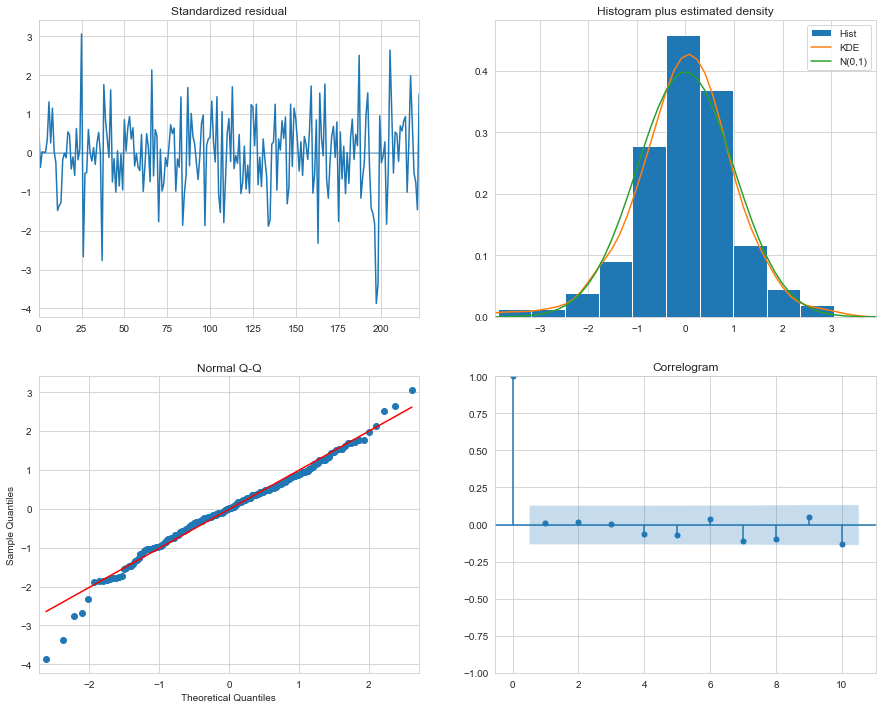

STARTED TO CONDUCT GRID SEARCHING FOR TOTAL 

LU decomposition error.
LU decomposition error.
LU decomposition error.


In [3]:
country = "vanuatu"
y_var = "total"
exog_var = ["covid", "stringency_index", str(country) + "_travel"]
method = None

# Set parameter range
p, d, q = range(0, 3), range(0, 2), range(0, 3)
P, D, Q, s = range(0, 3), range(0, 2), range(0, 3), [12]

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq, seasonal_pdq))
df = pd.DataFrame()

mod = SARIMAXPipeline(country=country, y_var=y_var,
                          data=None,
                          exog_var=exog_var,
                          transform_method=method,
                          training_ratio=1,
                          verbose=False)
mod.read_and_merge()
display(mod.data.head(5))

mod.transform()
print(f"The Benchmark Evaluation for {y_var}".upper(), "\n")
mod.get_benchmark_evaluation()
print(
    f"Started to conduct stepwise searching for {y_var}".upper(), "\n")
mod.stepwise_search()

print(f"Started to conduct Grid searching for {y_var}".upper(), "\n")
mod_msres = mod.manual_search(params=all_param)
mod_msres.sort(key=lambda x: x[1])

In [4]:
mod_pred = pd.DataFrame(mod_msres[1][0].fittedvalues, columns=["total_pred"])
mod_pred["total"] = mod.data["total"]
calculate_evaluation(mod_pred["total"], mod_pred["total_pred"])

{'MSE': 1248588.8904310048,
 'RMSE': 1117.4027431642562,
 'MAE': 810.4943302371165,
 'SMAPE': 34.07253718087036}

### Ensemble

In [15]:
performance = pd.DataFrame()
for num in range(2, 11):
    ensemble = pd.DataFrame()
    for res in mod_msres[1:num]:
        smod = res[0]
        smod_pred = mod.get_prediction_df(
            smod, mod.test_size, mod.exog[-mod.test_size:])
        
        smod_pred.columns.name = None
        pred = (smod_pred[["train_pred"]]
                .rename({"train_pred": str(res[-1])}, axis=1))
        if len(ensemble) == 0:
            ensemble = pred
        else:
            ensemble = pd.concat([ensemble, pred], axis=1)

    ensemble["mean"] = ensemble.mean(axis=1)
    ensemble["data"] = mod.data["date"]
    ensemble["total"] = mod.data["total"]

    eval_df = (pd.DataFrame(calculate_evaluation(ensemble["total"], ensemble["mean"]),
                            index=[num]))
    if len(performance) == 0:
        performance = pd.DataFrame(eval_df)
    else:
        performance = pd.concat([performance, eval_df], axis=0)

<AxesSubplot:>

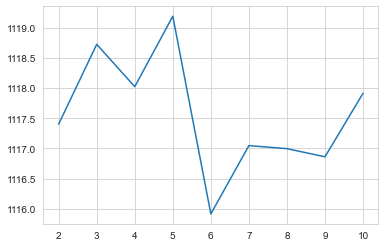

In [18]:
performance["RMSE"].plot()

## No Google Trends

,date,australia,new_zealand,new_caledonia,other_pic,europe,north_america,japan,china,other_countries,total,fileyear,not_stated,stringency_index,covid,vanuatu_flights,vanuatu_hotel,vanuatu_travel
0,2003-12-01,2938.0,580.0,646.0,136.0,201.0,88.0,42.0,0.0,103.0,4734.0,2007.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,2004-01-01,2864.0,439.0,717.0,122.0,186.0,67.0,36.0,0.0,61.0,4492.0,2005.0,0.0,0.0,0.0,2.232933,3.102047,2.453441
2,2004-02-01,2158.0,194.0,416.0,282.0,229.0,82.0,34.0,0.0,93.0,3488.0,2005.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,2004-03-01,2733.0,420.0,255.0,160.0,195.0,115.0,53.0,0.0,83.0,4014.0,2005.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,2004-04-01,2377.0,438.0,469.0,206.0,225.0,115.0,45.0,0.0,80.0,3955.0,2005.0,0.0,0.0,0.0,0.000000,0.000000,1.694580


training size : 224, testing size : 0
THE BENCHMARK EVALUATION FOR VANUATU 

STARTED TO CONDUCT STEPWISE SEARCHING FOR VANUATU 

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  224
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -278.336
Date:                            Wed, 14 Jun 2023   AIC                            570.671
Time:                                    10:40:17   BIC                            594.521
Sample:                                         0   HQIC                           580.299
                                            - 224                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

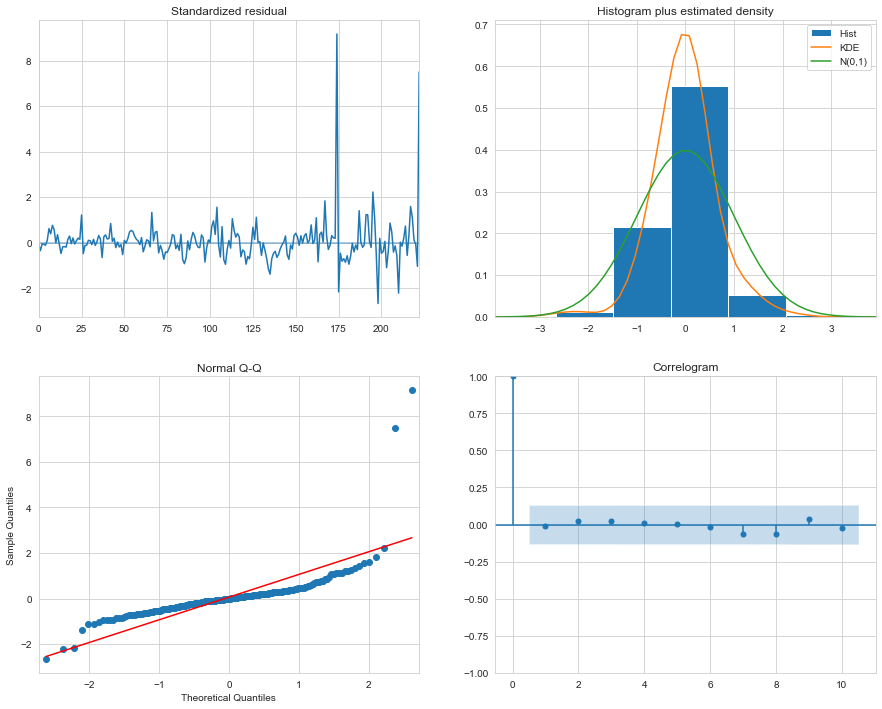

STARTED TO CONDUCT GRID SEARCHING FOR VANUATU 

STARTED TO CONDUCT CROSS-VALIDATION FOR VANUATU 

Best Models from Cross-validation is  ARIMA(1,0,1)(2,1,2)[12] intercept 



,MSE,RMSE,MAE,SMAPE
naive,2.915180e+06,1707.389827,1292.829596,20.537447
mean,1.125218e+07,3354.426412,2628.520727,47.767194
seasonal naive,8.396013e+06,2897.587484,1568.424107,34.617696
SARIMAX,1.257335e+06,1121.309621,802.838764,35.850816


In [19]:
countries = ["vanuatu"]
# Set parameter range
p, d, q = range(0, 3), range(0, 2), range(0, 3)
P, D, Q, s = range(0, 3), range(0, 2), range(0, 3), [12]

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq, seasonal_pdq))

for country in countries:

    mod = SARIMAXPipeline(country=country, y_var="total",
                          data=None,
                          exog_var=["covid", "stringency_index"],
                          transform_method="scaledlogit",
                          training_ratio=1,
                          verbose=False)
    mod.read_and_merge()
    display(mod.data.head(5))
    
    
    mod.transform()
    print(f"The Benchmark Evaluation for {country}".upper(), "\n")
    mod.get_benchmark_evaluation()
    print(f"Started to conduct stepwise searching for {country}".upper(), "\n")
    mod.stepwise_search()

    print(f"Started to conduct Grid searching for {country}".upper(), "\n")
    mod_msres = mod.manual_search(params=all_param)
    mod_msres.sort(key=lambda x: x[1])

    mod_swm = mod.stepwise_model
    if mod_msres[0][-1] == (mod_swm["order"], mod_swm["seasonal_order"]):
        print(mod_msres[0][-1])
    else:
        cv_models = []
        cv_models.append(pm.ARIMA(
            mod_swm["order"], mod_swm["seasonal_order"],  exog=mod.exog[:mod.training_size]))

        # Append top five GridSearch results
        for res in mod_msres[:5]:
            order, seasonal_order = res[-1]
            model = pm.ARIMA(order, seasonal_order,
                             exog=mod.exog[:mod.training_size])
            cv_models.append(model)

        print(
            f"Started to conduct Cross-validation for {country}".upper(), "\n")
        mod_cv_comp = mod.compare_models(
            y=mod.transformed_y, exog=mod.exog, models=cv_models)
        best_cv_idx = np.argmin(mod_cv_comp["avg_error"])
        print(
            f"Best Models from Cross-validation is {cv_models[best_cv_idx]}", "\n")

        if best_cv_idx > 0:
            best_mod = mod_msres[best_cv_idx-1][0]
            best_mod_pred = mod.get_prediction_df(
                best_mod, mod.test_size, mod.exog[-mod.test_size:])
        
        lower = mod.data["total"].min() - 1
        upper = mod.data["total"].max() + 1
        for col_idx, col in enumerate(best_mod_pred.columns):
            for row_idx, _ in enumerate(best_mod_pred[col]):
                best_mod_pred.iloc[row_idx, col_idx] = mod.inverse_scaledlogit(
                    best_mod_pred.iloc[row_idx, col_idx], upper, lower)

        # Merge the prediction with actual values
        best_mod_pred.columns.name = None
        best_mod_pred = pd.concat(
            [mod.data[["date", "total"]], best_mod_pred], axis=1)
        
        save_pred_path = mod.country_data_folder + "/model/sarimax_" + str(country) + ".csv"
        best_mod_pred.to_csv(save_pred_path, encoding="utf-8")

        if mod.test_size != 0:
            pred_series = (best_mod_pred["train_pred"].fillna(0)
                           + best_mod_pred["test_pred"].fillna(0))
        else:
            pred_series = best_mod_pred["train_pred"]
        
        mod_eval = (pd.DataFrame(calculate_evaluation(
            best_mod_pred["total"], pred_series), index=["SARIMAX"]))
        mod_eval = pd.concat([mod.benchmark, mod_eval], axis=0)
        display(mod_eval)